In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [2]:
!mkdir /kaggle/working/dataset

The syntax of the command is incorrect.


In [3]:
!cp -r /kaggle/input/lemon-quality-dataset/lemon_dataset/bad_quality /kaggle/working/dataset
!cp -r /kaggle/input/lemon-quality-dataset/lemon_dataset/empty_background /kaggle/working/dataset
!cp -r /kaggle/input/lemon-quality-dataset/lemon_dataset/good_quality /kaggle/working/dataset

'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!ls /kaggle/working/dataset

In [11]:
base_dir = "lemon_dataset"

In [12]:
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='training',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset='validation',
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
    
)

Found 2528 files belonging to 3 classes.
Using 2023 files for training.
Found 2528 files belonging to 3 classes.
Using 505 files for validation.


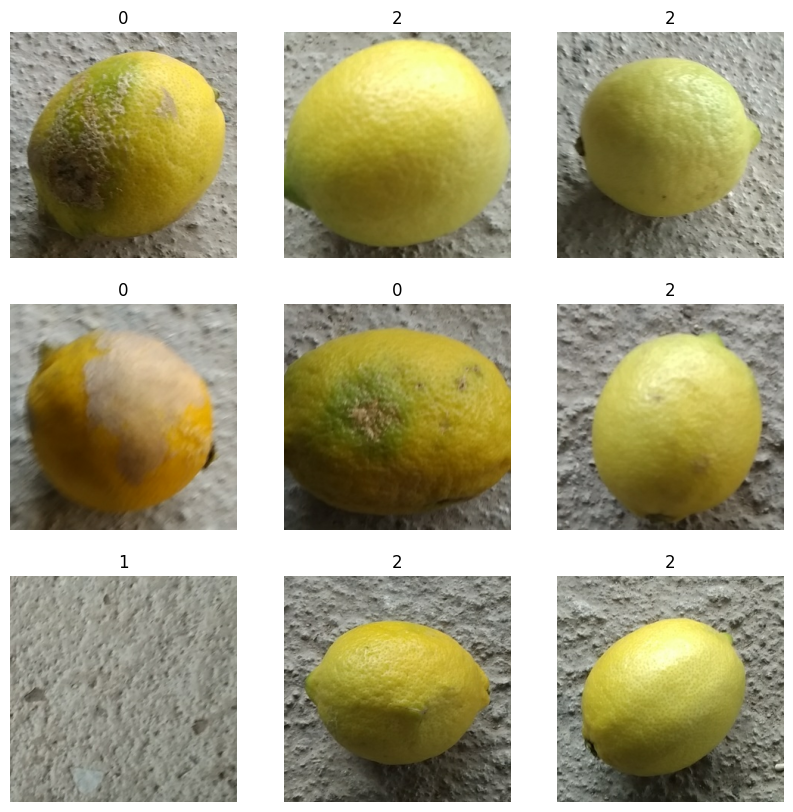

In [13]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("int"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [14]:
data_augmentation = keras.Sequential(
[
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
]
)

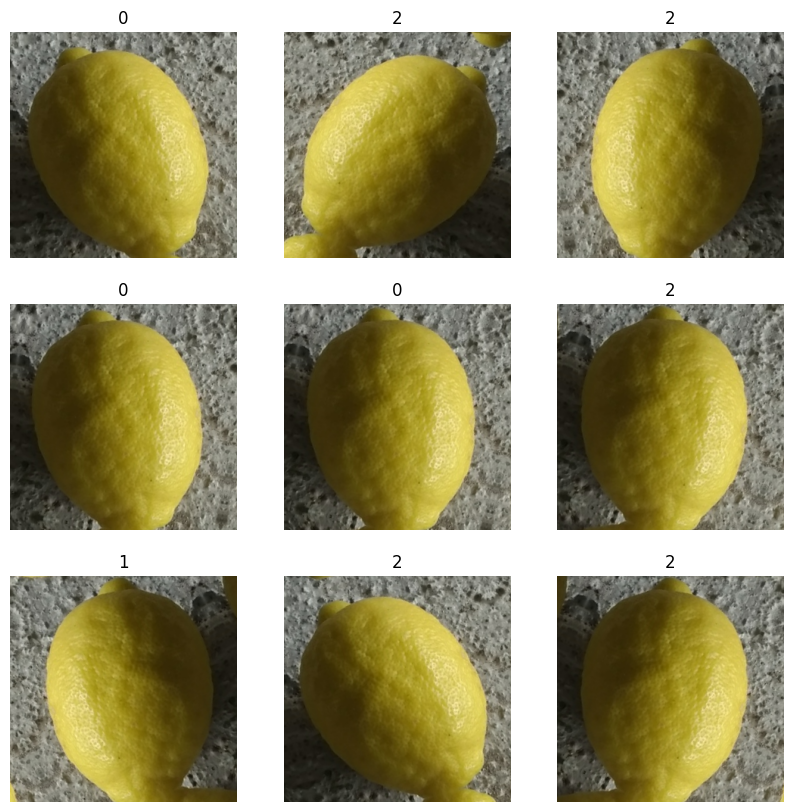

In [15]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_images = data_augmentation(images)
        plt.imshow(augmented_images[0].numpy().astype("int"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [16]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [17]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentaion block
    x = data_augmentation(inputs)
    
    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x # Set aside residual
    
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) # Add back residual
        previous_block_activation = x # Set aside next residual
    
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [41]:
model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("best_model_at_epoch_{epoch}.h5", save_best_only=True, monitor='val_accuracy', mode='max'),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valid_ds
)